# Exploring Wine Reviews

#### This dataset includes 130k wine reviews with variety, location, winery, price, and description

In [26]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
config = tf.ConfigProto(intra_op_parallelism_threads=1,
                        inter_op_parallelism_threads=1,)
config.gpu_options.allow_growth=True


import sklearn
import seaborn as sns

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

from sklearn.model_selection import train_test_split

from matplotlib.lines import Line2D

In [2]:
reviews = pd.read_csv("winemag-data-130k-v2.csv", index_col=0)
reviews

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


(129971, 13)


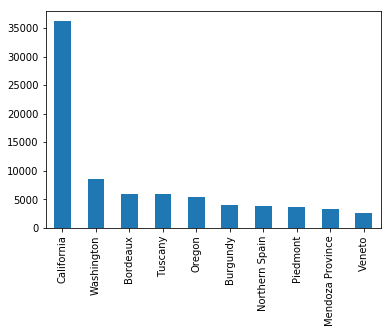

In [3]:
print(reviews.shape)
#Who produces the most wine?
reviews['province'].value_counts().head(10).plot.bar()

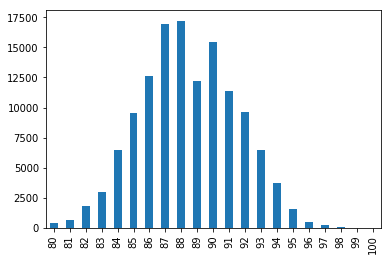

In [4]:
#What is the range in review points
#Ranked from 80-100
reviews['points'].value_counts().sort_index().plot.bar()

## Plotting Raw Data

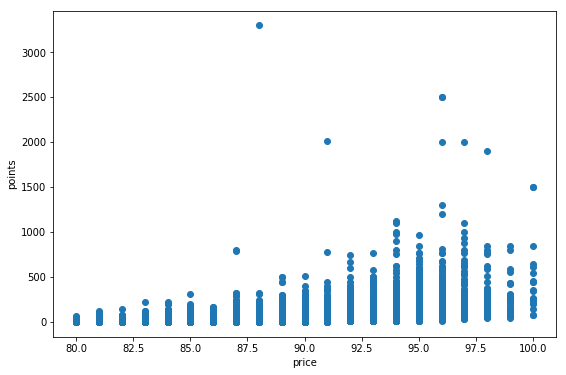

In [5]:
# As expected, there is a strong correlation between price and rating

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(reviews['points'], reviews['price'], 'o')
ax.set_xlabel('price')
ax.set_ylabel('points')
plt.show()

Pearson Correlation: (0.41616674186062297, 0.0)
                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                 9.509e+04
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        09:47:17   Log-Likelihood:            -6.7887e+05
No. Observations:              120975   AIC:                         1.358e+06
Df Residuals:                  120974   BIC:                         1.358e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pric

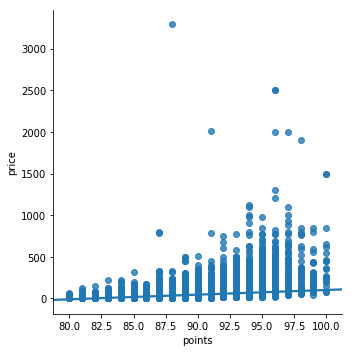

In [21]:
from scipy.stats import pearsonr
import statsmodels.api as sm

# dropping all null prices
reviews = reviews[pd.notnull(reviews.price)]

# As we can see in the summary, there is a positive correlation 
# $1.09 increase for every one point increase in rating

print("Pearson Correlation:", pearsonr(reviews.price, reviews.points))
print(sm.OLS(reviews.points, reviews.price).fit().summary())
sns.lmplot(y = 'price', x='points', data=reviews)


## K Means

In [6]:
# There are some duplicates of the descriptions so we can remove them
reviews[reviews['description'].duplicated(keep = False)].sort_values('description').head(8)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
67614,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
46540,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
119702,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
72181,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
73731,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie
100745,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie
73730,France,87-89 Barrel sample. Minty aromas give lifted ...,Barrel sample,88,NaN,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Haut-Sarpe 2008 Barrel sample (Saint-...,Bordeaux-style Red Blend,Château Haut-Sarpe
100744,France,87-89 Barrel sample. Minty aromas give lifted ...,Barrel sample,88,NaN,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Haut-Sarpe 2008 Barrel sample (Saint-...,Bordeaux-style Red Blend,Château Haut-Sarpe


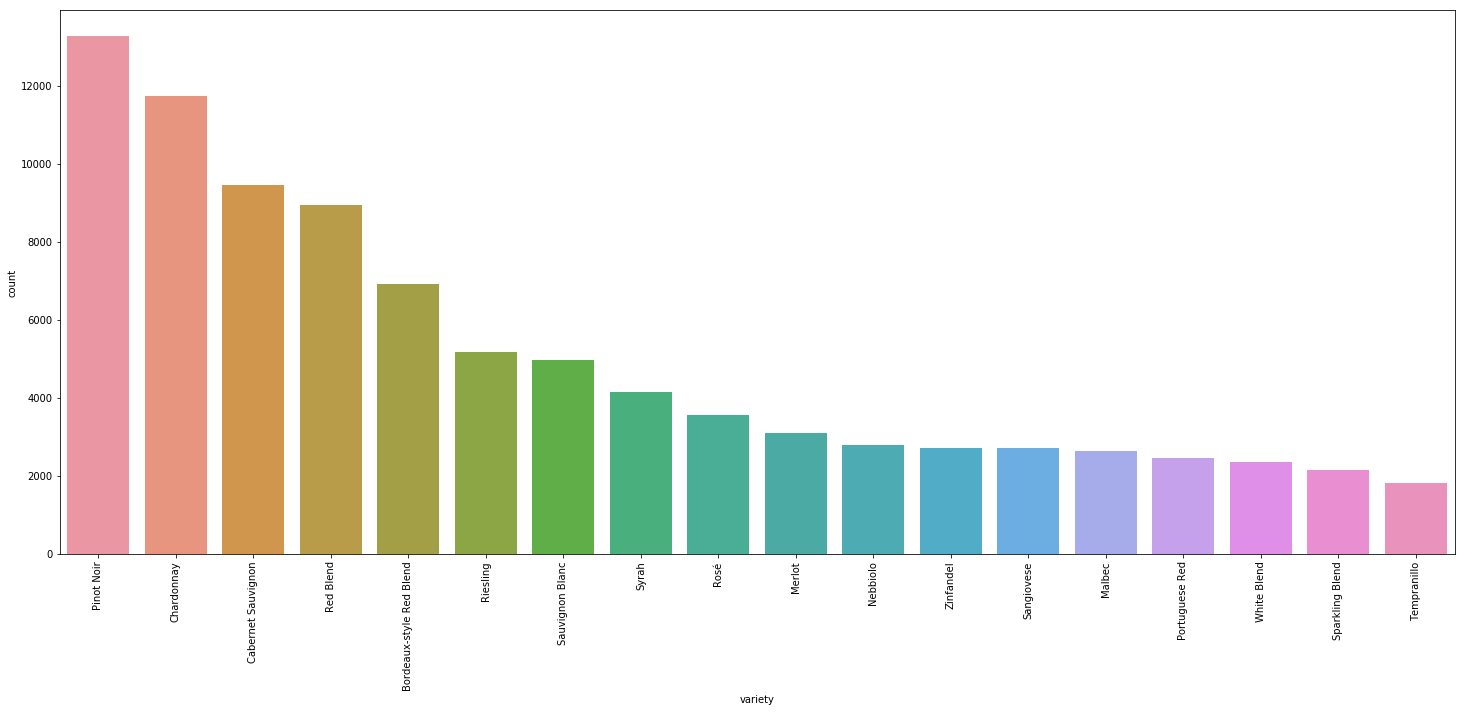

In [7]:
# There are so many distinct types of wine in the dataset that if we tried to cluster it would
# Be too many different types of clusters
# To make it easier, we are keeping any wine variety that has more than 1500 entries
# Although all of the data is now not included, it makes it more reasonable to analyze

variety_df = reviews.groupby('variety').filter(lambda x: len(x) > 1500)
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()



In [8]:
#Went from 130,000 to 90,000
print(variety_df.shape)

(90988, 13)


In [9]:
#Natural Language Processing

# Adding punctuation to list of stop words
# Sklearn already has a premade list of stop words we are just adding punc
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = variety_df['description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)


# You can see that there are many words that are similar and sklearn cannot distinguish them differently
word_features = vectorizer.get_feature_names()
word_features[550:575]

['abandon',
 'abandoned',
 'abate',
 'abbess',
 'abbey',
 'abboccato',
 'abbot',
 'abbott',
 'abbreviated',
 'abc',
 'abeille',
 'abeja',
 'abel',
 'abernathy',
 'aberrant',
 'abetina',
 'abeyance',
 'abide',
 'abilio',
 'abilities',
 'ability',
 'abiouness',
 'able',
 'ably',
 'abnormal']

## Using Natural Language Processing Toolkit

In [10]:
# Tool Kit has methods for reducing words to their root forms
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [11]:
#Can see that only the root form is visible because of the stemming that was added
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()
word_features2[:50]

/home/webermn/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


["'s",
 "a'",
 "a'plenti",
 'aa',
 'aand',
 'aaron',
 'abacela',
 'abad',
 'abadia',
 'abandon',
 'abat',
 'abbess',
 'abbey',
 'abboccato',
 'abbot',
 'abbott',
 'abbrevi',
 'abc',
 'abeill',
 'abeja',
 'abel',
 'abernathi',
 'aberr',
 'abetina',
 'abey',
 'abid',
 'abil',
 'abilio',
 'abiou',
 'abl',
 'abli',
 'abnorm',
 'aboard',
 'abondant',
 'aborigin',
 'abound',
 'abouriou',
 'abov',
 'abovd',
 'abras',
 'abreu',
 'abri',
 'abrigo',
 'abroad',
 'abrupt',
 'abruzzo',
 'absberg',
 'absenc',
 'absent',
 'absolut']

In [12]:
# adjusting the max features parameter 
# will now only select the top max features token ordered by their frequencies 

vectorizer3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X3 = vectorizer3.fit_transform(desc)
words = vectorizer3.get_feature_names()

/home/webermn/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


## K Means Clustering

In [13]:
# Used a n_init of 5 so that it would run faster
# Means 5 different centriod initializations 
# Takes ~7 min to run 

kmeans = KMeans(n_clusters = 15, n_init = 5, n_jobs = -1)
kmeans.fit(X3)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=5, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
# Top 10 most frequented words in each cluster

common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : wine, fruit, flavor, cherri, finish, aroma, spice, tannin, red, raspberri
1 : lemon, riesl, lime, dri, peach, finish, palat, miner, acid, flavor
2 : appl, pear, flavor, palat, green, lemon, finish, fresh, aroma, wine
3 : cabernet, sauvignon, merlot, blend, franc, petit, verdot, black, cherri, syrah
4 : blackberri, flavor, currant, cherri, sweet, tannin, dri, oak, wine, rich
5 : bodi, medium, wine, flavor, textur, finish, aroma, cherri, light, fruit
6 : berri, aroma, finish, plum, flavor, herbal, feel, palat, note, oak
7 : wood, age, wine, fruit, rich, drink, ripe, tannin, structur, acid
8 : wine, fruiti, acid, drink, crisp, readi, fruit, attract, soft, light
9 : wine, structur, fruit, tannin, firm, rich, age, ripe, drink, dens
10 : black, cherri, nose, palat, pepper, fruit, plum, flavor, aroma, dark
11 : citrus, blanc, white, flavor, finish, fruit, aroma, melon, palat, sauvignon
12 : pinot, noir, cherri, raspberri, flavor, silki, cola, acid, dri, drink
13 : palat, tannin, alongsid,

In [15]:
variety_df['cluster'] = kmeans.labels_

/home/webermn/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


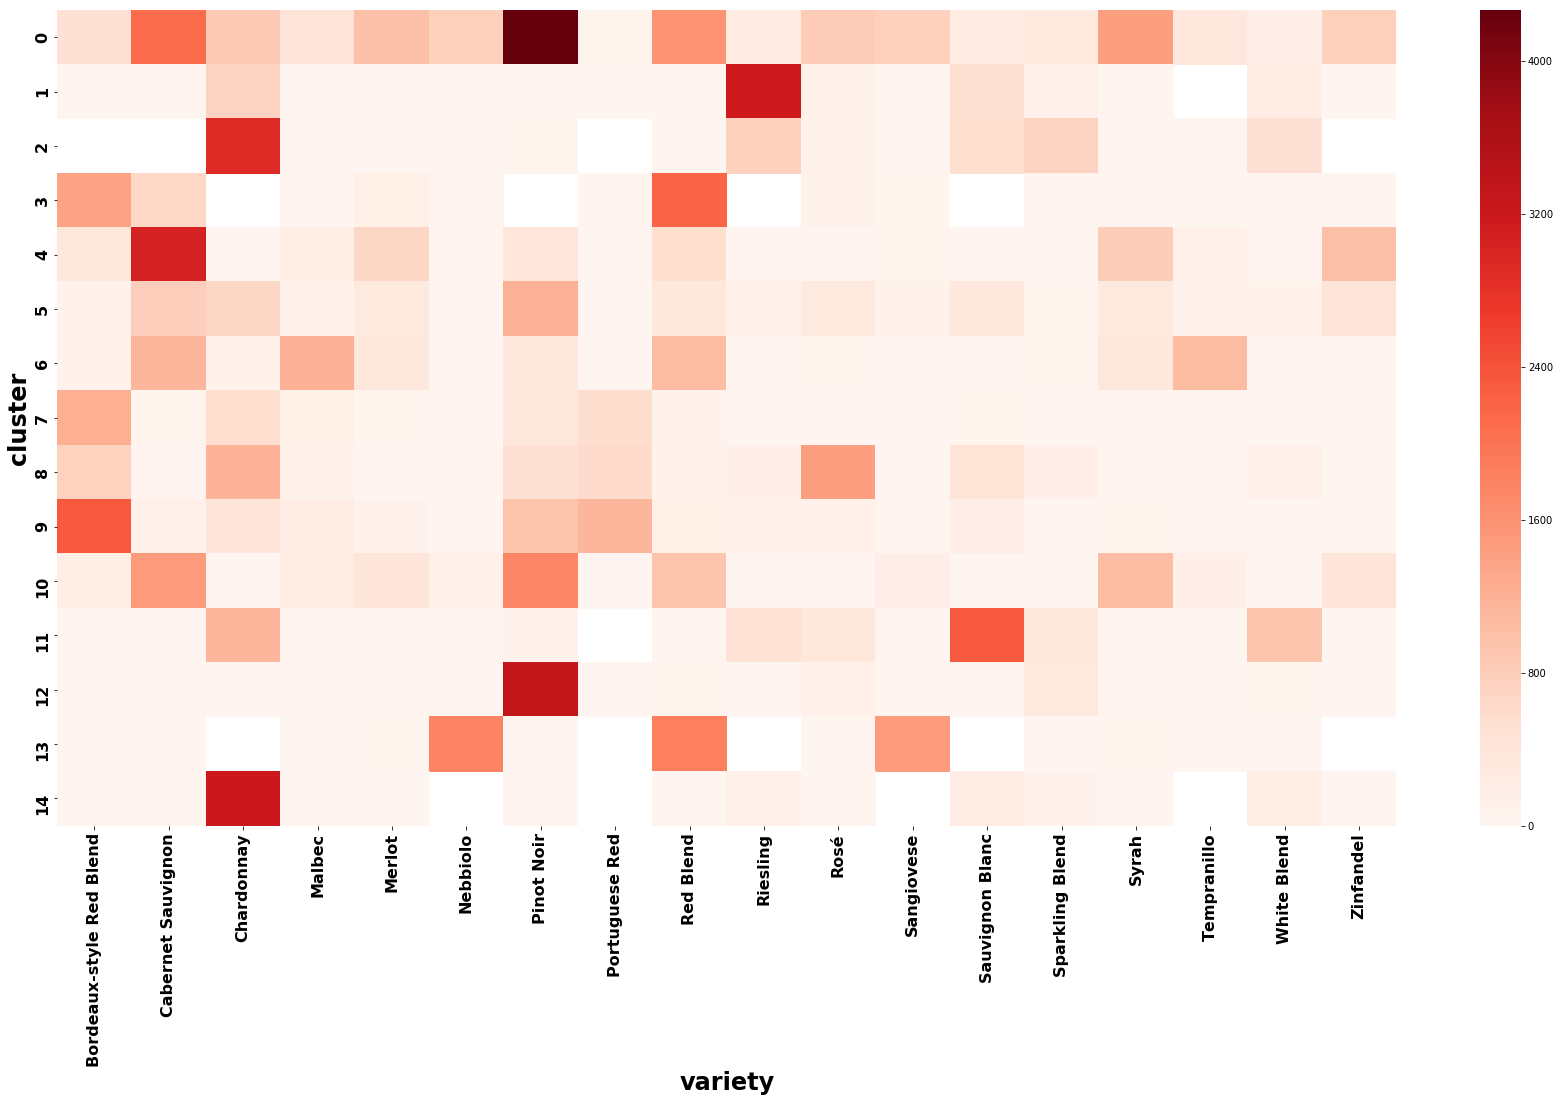

In [16]:
# The Top 15 types of wine that we saw earlier
# Want to see how much each of these wines appears in each cluster
clusters = variety_df.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")
    
# Although clustering was not able to find one-to-one relationship between 
# each of the 15 types of wines, there are certain clusters that greatly
# represent certain wines (0 and Pinot Noir)

# One area for improvement is to go back and look for more stop words
# Can also remove the names of the wines 
# Could play around with the number of clusters 

## Logistic Regression

In [59]:
# Was not working with null values so had to drop them
data = variety_df.drop_duplicates('description')
data = data[pd.notnull(data.price)]
data.shape

(78915, 14)

In [60]:
# Want to compare description and the variety for the regression so dropping all unncessary columns

X = data.drop(['country','designation','points','province','region_1','region_2','variety','winery'], axis = 1)
y = data.variety

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(59186, 6) (19729, 6) (59186,) (19729,)


In [61]:
# Sorting by different wine names
wine = data.variety.unique().tolist()
wine.sort()
wine[:10]

['Bordeaux-style Red Blend',
 'Cabernet Sauvignon',
 'Chardonnay',
 'Malbec',
 'Merlot',
 'Nebbiolo',
 'Pinot Noir',
 'Portuguese Red',
 'Red Blend',
 'Riesling']

In [62]:
# Sorting by the variety of wine

output = set()
for x in data.variety:
    x = x.lower()
    x = x.split()
    for y in x:
        output.add(y)

variety_list =sorted(output)
variety_list[:10]

['blanc',
 'blend',
 'bordeaux-style',
 'cabernet',
 'chardonnay',
 'malbec',
 'merlot',
 'nebbiolo',
 'noir',
 'pinot']

In [54]:
# Downloading the nltk premade list of stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/webermn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
# Different method for implementing stop words with our own values

extras = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', 'cab',"%"]
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.update(variety_list)
stop.update(extras)

In [64]:
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words = stop)
X_train_dtm = vect.fit_transform(X_train.description)
price = X_train.price.values[:,None]
X_train_dtm = hstack((X_train_dtm, price))
X_train_dtm

/home/webermn/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bordeaux', 'style'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<59186x23149 sparse matrix of type '<class 'numpy.float64'>'
	with 1490573 stored elements in COOrdinate format>

In [65]:
X_test_dtm = vect.transform(X_test.description)
price_test = X_test.price.values[:,None]
X_test_dtm = hstack((X_test_dtm, price_test))
X_test_dtm

<19729x23149 sparse matrix of type '<class 'numpy.float64'>'
	with 494051 stored elements in COOrdinate format>

In [66]:
from sklearn.linear_model import LogisticRegression
models = {}
for z in wine:
    model = LogisticRegression()
    y = y_train == z
    model.fit(X_train_dtm, y)
    models[z] = model

testing_probs = pd.DataFrame(columns = wine)

In [67]:
for variety in wine:
    testing_probs[variety] = models[variety].predict_proba(X_test_dtm)[:,1]
    
predicted_wine = testing_probs.idxmax(axis=1)

comparison = pd.DataFrame({'actual':y_test.values, 'predicted':predicted_wine.values})   

from sklearn.metrics import accuracy_score
print('Accuracy Score:',accuracy_score(comparison.actual, comparison.predicted)*100,"%")
comparison.head(5)

Accuracy Score: 64.82335648030818 %


,actual,predicted
0,Chardonnay,Chardonnay
1,Pinot Noir,Pinot Noir
2,Syrah,Cabernet Sauvignon
3,Cabernet Sauvignon,Red Blend
4,Pinot Noir,Pinot Noir


# Got a final accuracy of 64.8%

### Ways for possible improvement?
##### Dropping blends out of the testing? There are specific words that go with non-blended wines (ex. buttery and Chardonnay) 
##### There are also some rows that contain the same types of wine but in different languages
##### Do not currently have enough knowledge to go through and clean this out but could be a room for improvement